In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import os
import scipy
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from src.grn import grn

In [2]:
fname = 'networks.v2.stability2.csv'

if not os.path.exists(fname):  
    networks = pd.read_csv('networks.v2.figs.csv', index_col=0)
    for i in tqdm(networks.index):
        G = nx.read_gpickle(networks.loc[i, 'files'][:-6]+'.gpickle')
        # properties
        B = G.beta 
        x = G.rna.flatten()
        l = G.l.flatten()
        a = G.alpha.flatten()
    
        # jacobian
        sig = scipy.special.expit(a + B.T@x.reshape(-1,1))
        #sig = (l*x)
        A = B.T * (sig * (1 - sig)) - np.diag(l)
        evals, evecs = np.linalg.eig(A)
        
        # result
        networks.loc[i,'stable'] = all(evals.real < 0)
        networks.loc[i,'Jmax'] = max(evals.real)
    networks.to_csv(fname)
else:
    networks = pd.read_csv(fname, index_col=0)

100%|██████████| 1920/1920 [1:48:56<00:00,  3.40s/it]


In [3]:
networks.head()

,files,n,k,r,delta_in,delta_out,w,rho_r_ko,ap_ko,ap_r2,stable,Jmax
1,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,1,-0.008498,0.354114,0.001309,True,-0.275835
2,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,9,-0.008018,0.317248,0.001118,True,-0.174709
3,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,40,-0.007941,0.417463,0.001076,True,-0.438318
4,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,90,-0.005223,0.376424,0.001153,True,-0.413382
5,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,400,-0.008401,0.400828,0.001114,True,-0.214086


In [4]:
networks['stable'].mean()

0.8817708333333333

In [5]:
home='../../../../projects/genetwork/grn-paper'
ko=np.load(home+'/ko.npy', mmap_mode='r')
rna=np.load(home+'/rna.npy', mmap_mode='r')
lowE = (rna < 1e-3)

networks['100tgs'] = [np.sum(np.sum(np.abs(ko[ix,:,:][np.ix_(~lowE[ix,:],~lowE[ix,:])]) > 1e-1, axis=1) > 99) 
                      for ix in tqdm(range(len(networks)))]

100%|██████████| 1920/1920 [02:38<00:00, 12.12it/s]


In [6]:
networks['k_adj'] = networks['k'].replace({1:2000})

/tmp/ipykernel_13507/3855909079.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);
/tmp/ipykernel_13507/3855909079.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);
/tmp/ipykernel_13507/3855909079.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);


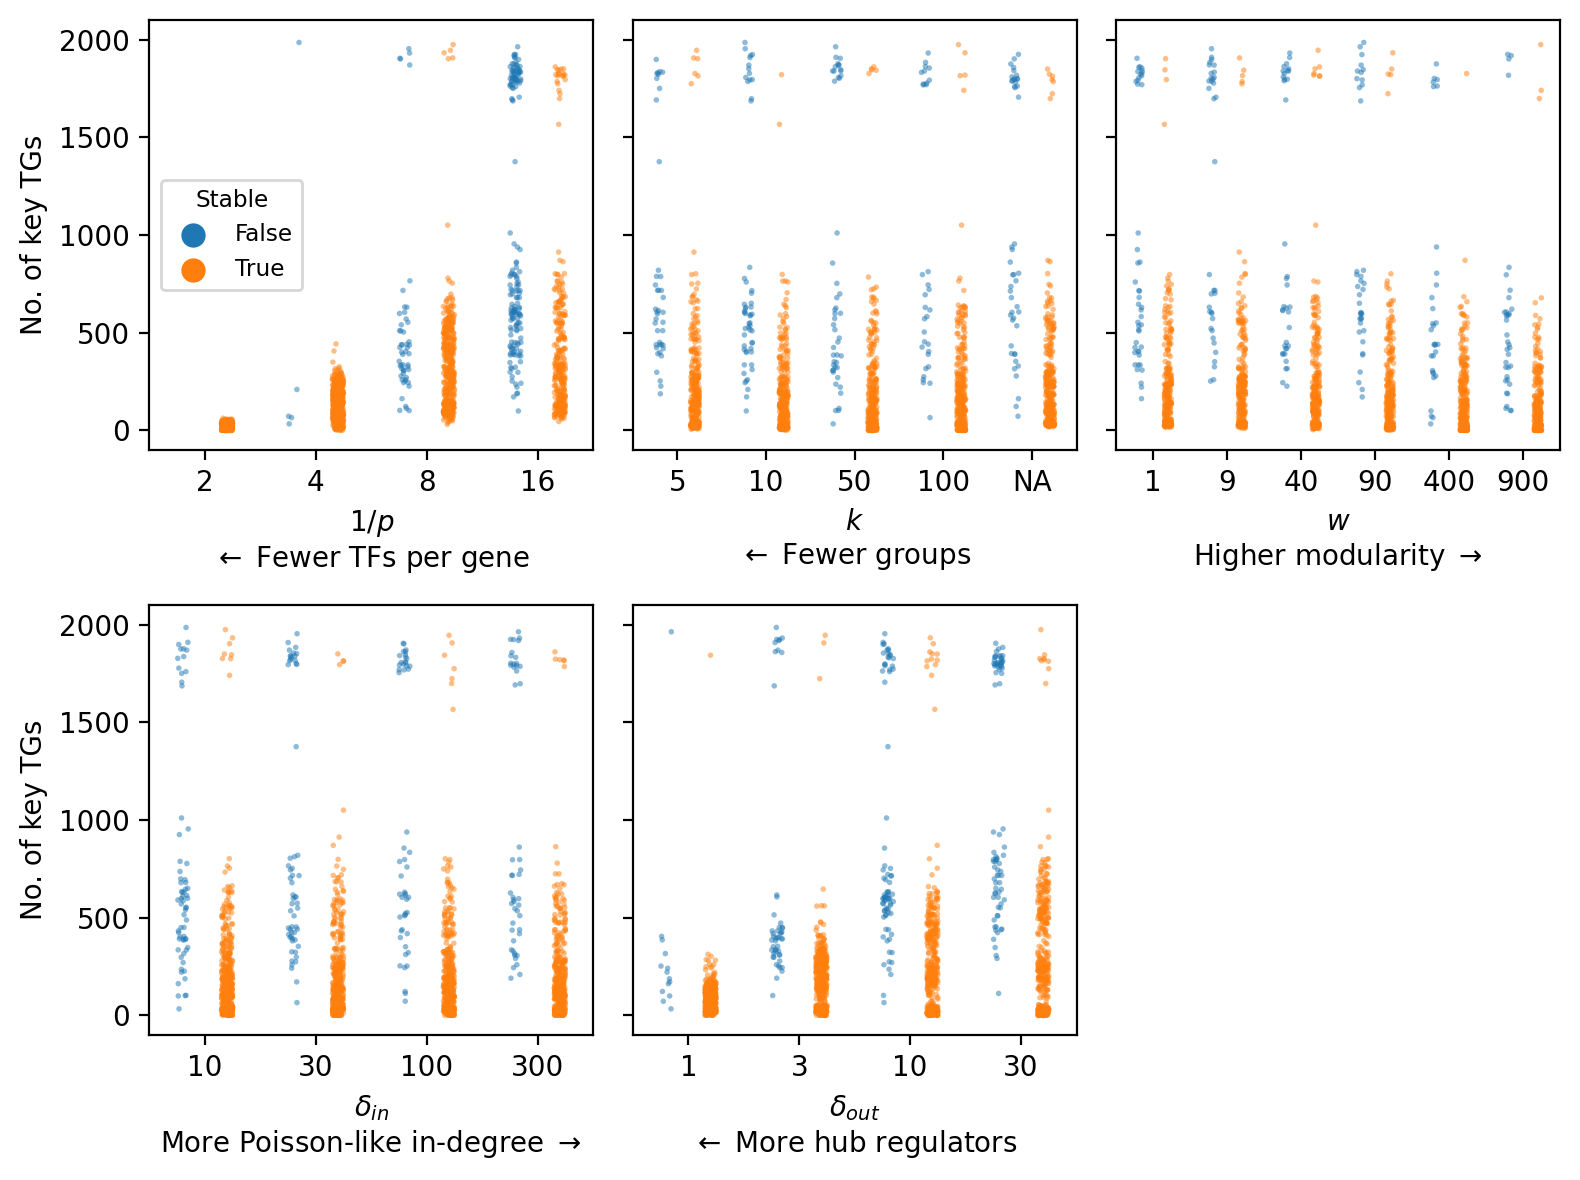

In [7]:
sns.set_style(None)

props=['r','k_adj','w','delta_in','delta_out']

names=[r'$1/p$'+'\n'+r'$\leftarrow$'+' Fewer TFs per gene', 
       r'$k$'+'\n'+r'$\leftarrow$'+' Fewer groups', 
       r'$w$'+'\nHigher modularity '+r'$\rightarrow$', 
       r'$\delta_{in}$'+'\nMore Poisson-like in-degree '+r'$\rightarrow$',
       r'$\delta_{out}$'+'\n'+r'$\leftarrow$'+' More hub regulators']

stats=['100tgs']
shortlabs=['No. of key TGs']
statdescs=['Number of key TGs per network, with 100 upstream effects at |logFC| > 0.1']

fig, ax = plt.subplots(len(stats) * 2, 1 + len(props) // 2, figsize=(8,6), dpi=200)
fig.set(facecolor='white')
d1, d2 = len(props), len(stats)
#ax = ax.reshape(1,-1)

for i2,(prop,name) in enumerate(zip(props,names)):
    for i1,(stat, shortlab) in enumerate(zip(stats,shortlabs)):
        i1 = i2 // 3
        i2 = i2 % 3
        sns.stripplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      dodge = True,
                      alpha = 0.5, 
                      size = 2,
                      zorder = 1, 
                      hue = 'stable',
                      ax = ax[i1, i2]
        )
        mep="""
        sns.pointplot(data = networks, 
                      y = stat, 
                      x = prop,
                      orient = 'v',
                      estimator = np.mean,
                      dodge = .8 - .8 / 3,
                      errorbar = ('ci', 0.95),
                      scale = 0.9,
                      linestyles = 'none',
                      hue = 'stable',
                      #palette = "dark",
                      markers = 'd', 
                      ax = ax[i1, i2]
        )"""
        if prop != 'r':
            ax[i1,i2].legend([], frameon=0);
        else:
            ax[i1,i2].legend(fontsize='small', title_fontsize='small', title='Stable');
        if prop == 'k_adj':
            ax[i1,i2].set_xticklabels([l if l.get_text() != '2000' else 'NA' for l in ax[i1,i2].get_xticklabels()]);
        ax[i1, i2].set_xlabel(name);
        #ax[i1, i2].semilogy();
        if i2 == 0:
            ax[i1, i2].set_ylabel(shortlab)
        else:
            ax[i1, i2].set_ylabel('');
            ax[i1, i2].set_yticklabels(['' for _ in ax[i1,i2].get_yticklabels()]);
        ax[i1, i2].set_ylim(-100, 2100);

ax[1,2].set_visible(0);
fig.tight_layout();
plt.savefig('png/supplement/fig_s4_stability.png');

In [8]:
for prop in props:
    display(networks.groupby(prop)['stable'].mean())

r
2     1.000000
4     0.989583
8     0.891667
16    0.645833
Name: stable, dtype: float64

k_adj
5       0.890625
10      0.854167
50      0.872396
100     0.914062
2000    0.877604
Name: stable, dtype: float64

w
1      0.856250
9      0.884375
40     0.881250
90     0.878125
400    0.903125
900    0.887500
Name: stable, dtype: float64

delta_in
10     0.862500
30     0.877083
100    0.891667
300    0.895833
Name: stable, dtype: float64

delta_out
1     0.970833
3     0.893750
10    0.831250
30    0.831250
Name: stable, dtype: float64

In [9]:
for i in tqdm(networks.index):
    G = nx.read_gpickle(networks.loc[i, 'files'][:-6]+'.gpickle')
    # properties
    B = G.beta 
    x = G.rna.reshape(-1,1)
    l = G.l
    alpha = G.alpha

    networks.loc[i,'resid'] = max(scipy.special.expit(B.T @ x + alpha) - (l * x))

100%|██████████| 1920/1920 [20:43<00:00,  1.54it/s]


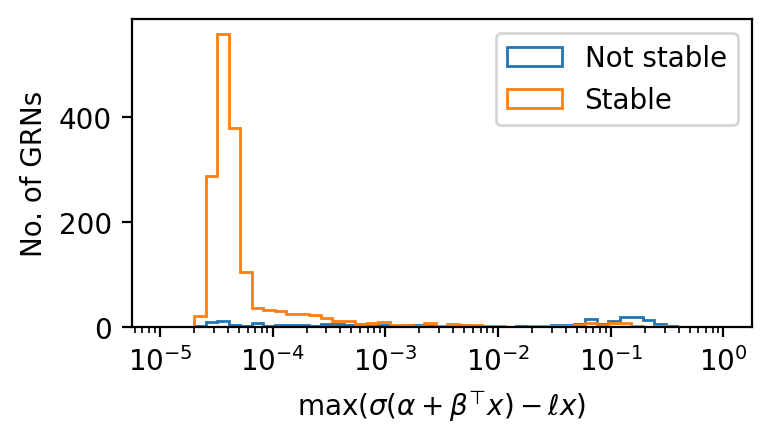

In [10]:
plt.figure(figsize=(4,2), dpi=200);

for ix,l in zip([~networks.stable.astype(bool), networks.stable], ['Not stable', 'Stable']):
    plt.hist(networks.loc[ix, 'resid'].clip(lower=1e-5), 
             bins = np.geomspace(1e-5, 1e0, 50),
             histtype = 'step',
             label = l
            );

plt.xlabel(r'$\max( \sigma(\alpha + \beta^\top x) - \ell x)$'); 
plt.ylabel('No. of GRNs');
plt.legend();
plt.semilogx();

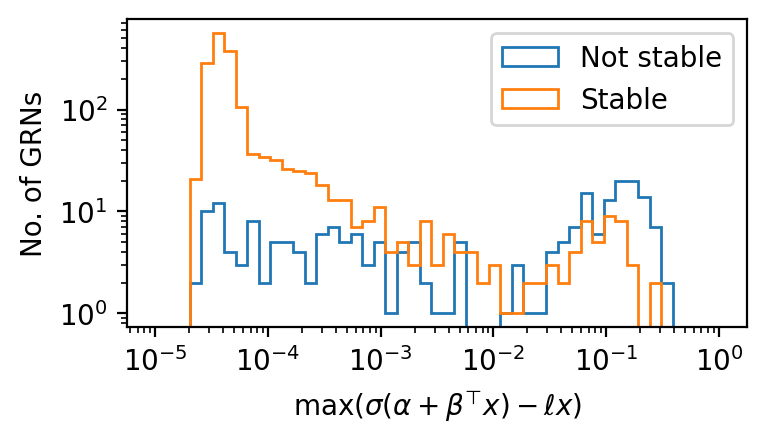

In [11]:
plt.figure(figsize=(4,2), dpi=200);

for ix,l in zip([~networks.stable.astype(bool), networks.stable], ['Not stable', 'Stable']):
    plt.hist(networks.loc[ix, 'resid'].clip(lower=1e-5), 
             bins = np.geomspace(1e-5, 1e0, 50),
             histtype = 'step',
             label = l
            );

plt.xlabel(r'$\max( \sigma(\alpha + \beta^\top x) - \ell x)$'); 
plt.ylabel('No. of GRNs');
plt.legend();
plt.loglog();